<a href="https://colab.research.google.com/github/Yassmina-Abdo/natural-language-processing/blob/main/tweets_classification_Lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**The same task as Lab 1 except using `Word Embeddings OR RNNs`**

**Watch out!<br>
Preproceesing here is a a bit different<br>
Just take the cleaned data from the previous lab and cont...**


**Dataset**
labeled datasset collected from twitter

**Objective**
classify tweets containing hate speech from other tweets.
0 -> no hate speech
1 -> contains hate speech

**Total Estimated Time = 60 Mins**

### Import Libraries

In [ ]:
!pip install contractions --q

     |████████████████████████████████| 106 kB 53.6 MB/s 
     |████████████████████████████████| 287 kB 54.2 MB/s 


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras import optimizers
from sklearn.utils import shuffle
from sklearn import metrics
import contractions
from tensorflow.keras.layers import *
from tensorflow.keras import models,layers
import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
import pandas as pd
import re

### Load Dataset

In [ ]:
df = pd.read_csv('dataset.csv',index_col='id')

In [ ]:
df.head()

,label,tweet
id,,
1,0,@user when a father is dysfunctional and is s...
2,0,@user @user thanks for #lyft credit i can't us...
3,0,bihday your majesty
4,0,#model i love u take with u all the time in ...
5,0,factsguide: society now #motivation


In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31962 entries, 1 to 31962
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   31962 non-null  int64 
 1   tweet   31962 non-null  object
dtypes: int64(1), object(1)
memory usage: 749.1+ KB
None


In [ ]:
df=df.drop_duplicates()

### Preprocessing


In [ ]:
def preprocess(text): 
  text = text.lower() #1.lower
  text= contractions.fix(text)  #2.contractions 
  text = re.sub('@(\w+)',"", text )  #3. remove username
  text=  re.sub(r'[^\w\s]', '',  text)   #4. punc
  return text   

In [ ]:
df['tweet'] = df['tweet'].apply(lambda x: preprocess(x))

In [ ]:
df.sample(5)

,label,tweet
id,,
16433,0,you have the power to heal yourself louise ha...
26512,0,a flower dancing happily away in the breeze a ...
8238,0,fathers day the best forever louis your b...
18452,0,the midnight league teams have arrived for ...
19699,0,getting ready for canneslions creative ads ins...


## Tokens

In [ ]:
MAX_NB_WORDS = 50000
MAX_SEQUENCE_LENGTH = 250
EMBEDDING_DIM = 100
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['tweet'].values)
word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print('Found %s unique tokens.' % len(word_index))

Found 45057 unique tokens.


In [ ]:
X = tokenizer.texts_to_sequences(df['tweet'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (29530, 250)


In [ ]:
Y = df['label'].values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (29530,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(23624, 250) (23624,)
(5906, 250) (5906,)


### Modelling
**Use any Advanced technique such as: word2vec, glove, RNNs ... etc**

In [ ]:
model = tf.keras.models.Sequential()
# model.add(layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[0]))
model.add(layers.Embedding(vocab_size, 128, mask_zero=True))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer=optimizers.RMSprop(learning_rate=0.01),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=5, batch_size=256,validation_split=0.1,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


Epoch 1/5
84/84 [==============================] - 112s 1s/step - loss: 0.2087 - accuracy: 0.9358 - val_loss: 0.1517 - val_accuracy: 0.9450
Epoch 2/5
84/84 [==============================] - 105s 1s/step - loss: 0.0696 - accuracy: 0.9772 - val_loss: 0.1609 - val_accuracy: 0.9534
Epoch 3/5
84/84 [==============================] - 105s 1s/step - loss: 0.0298 - accuracy: 0.9901 - val_loss: 0.2081 - val_accuracy: 0.9204
Epoch 4/5
84/84 [==============================] - 106s 1s/step - loss: 0.0162 - accuracy: 0.9945 - val_loss: 0.2105 - val_accuracy: 0.9365


#### Evaluation

In [ ]:
def predict_tweet_sentiment(score):
    return "Positive" if score>0.5 else "Negative"
scores = model.predict(X_test, verbose=1, batch_size=10000)
model_predictions = [predict_tweet_sentiment(score) for score in scores]

1/1 [==============================] - 1s 616ms/step


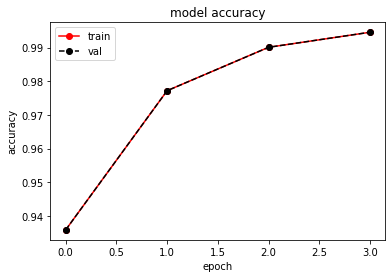

In [ ]:
plt.plot(history.history['accuracy'],'r-o')
plt.plot(history.history['accuracy'],'k--o')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

**OverFitting Case**

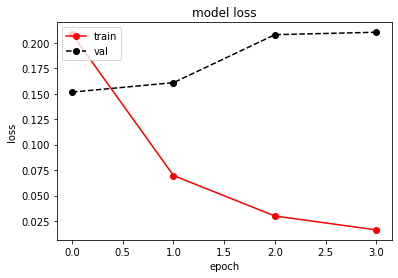

In [ ]:
plt.plot(history.history['loss'], 'r-o')
plt.plot(history.history['val_loss'],'k--o')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### Done!